loading training data
loading test data
step 0, training accuracy 0.466946
step 0, cost 339.836
step 0, change in cost 339.836
step 1000, training accuracy 0.762854
step 1000, cost 196.134
step 1000, change in cost 0.377869
step 2000, training accuracy 0.83106
step 2000, cost 157.604
step 2000, change in cost 0.378098
step 3000, training accuracy 0.868835
step 3000, cost 123.274
step 3000, change in cost 0.30291
step 4000, training accuracy 0.900315
step 4000, cost 97.4123
step 4000, change in cost 0.216988
step 5000, training accuracy 0.919203
step 5000, cost 79.2478
step 5000, change in cost 0.151108
step 6000, training accuracy 0.929696
step 6000, cost 66.4726
step 6000, change in cost 0.108063
step 7000, training accuracy 0.941238
step 7000, cost 57.1539
step 7000, change in cost 0.080616
step 8000, training accuracy 0.955929
step 8000, cost 50.0612
step 8000, change in cost 0.0626411
step 9000, training accuracy 0.962225
step 9000, cost 44.4506
step 9000, change in cost 0.0504379


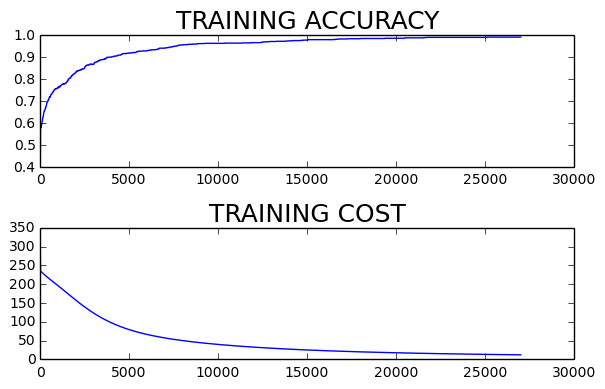

In [3]:
# # Preamble
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
get_ipython().magic('matplotlib inline')


# # Import Data

def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()


# # Global Parameters

# In[3]:

# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]
numHidden = 8

# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)


# # Placeholders

# In[4]:

# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])


# # Variables

# In[5]:

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights_1_2 = tf.Variable(tf.random_normal([numFeatures,numHidden],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numHidden+1)),
                                       name="weights_1_2"))

bias_hidden = tf.Variable(tf.random_normal([1,numHidden],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias_hidden"))

weights_2_3 = tf.Variable(tf.random_normal([numHidden,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numHidden+
                                                         numLabels+1)),
                                       name="weights_2_3"))

bias_out = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias_out"))


# # Prediction Ops

# In[6]:

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# Neural Network

apply_weights_1 = tf.matmul(X, weights_1_2, name="apply_weights")
add_bias_1 = tf.add(apply_weights_1, bias_hidden, name="add_bias")
activation_1 = tf.nn.sigmoid(add_bias_1, name="activation")

apply_weights_OP = tf.matmul(activation_1, weights_2_3, name="apply_weights2")
add_bias_OP = tf.add(apply_weights_OP, bias_out, name="add_bias2")
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation2")


# # Evaluation Ops

# In[7]:

cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")


# # Optimization Op

# In[8]:

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)


# In[ ]:

epoch_values=[]
accuracy_values=[]
cost_values=[]


# # Run the Graphs

# In[ ]:

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))


# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run(
                [accuracy_OP, cost_OP],
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            #writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            if i % 1000 == 0:
                print("step %d, training accuracy %g"%(i, train_accuracy))
                print("step %d, cost %g"%(i, newCost))
                print("step %d, change in cost %g"%(i, diff))

          
            #time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP,
                                                     feed_dict={X: testX,
                                                                yGold: testY})))


# # Graph Live Updating

# In[ ]:

# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

# Plot progress to our two subplots
accuracyLine, = ax1.plot(epoch_values, accuracy_values)
costLine, = ax2.plot(epoch_values, cost_values)
fig.canvas.draw()
